# 6-3. Image Classification w/ pre-trained ResNet model -- custom dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
%cd /content/drive/MyDrive/제목없는 폴더

/content/drive/MyDrive/제목없는 폴더


In [21]:
!unzip archive_1.zip

Archive:  archive_1.zip
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/1473187633_63ccaacea6.jpg  
  inflating: hymenoptera_data/train/ants/148715752_302c84f5a4.jpg  
  inflating: hymenoptera_da

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.deevice('cpu')

print('Using PyTorch version: ', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version:  2.2.1+cu121  Device:  cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val' : transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/제목없는 폴더/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, shuffle = True) for x in ['train', 'val']}

In [6]:
for (X_train, y_train) in dataloaders['train']:
  print('X_train: ', X_train.size(), 'type: ', X_train.type())
  print('y_train: ', y_train.size(), 'type: ', y_train.type())
  break

X_train:  torch.Size([32, 3, 224, 224]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


In [7]:
y_train

tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 0])

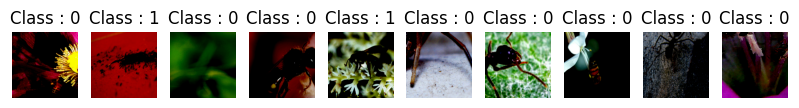

In [8]:
pltsize = 1
plt.figure(figsize = (10*pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1,2,0)))
  plt.title('Class : ' + str(y_train[i].item()))

In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [10]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()

for parameter in model.parameters():
  parameter.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

# import torchvision.models as models
# model = models.resnet34(pretrained = True)
# print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# for parameter in model.parameters():
#   parameter.requires_grad = False

# num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 2),
#     nn.Sigmoid()
# )

# model = model.to(DEVICE)

In [14]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.704582
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.707137
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.711257

[EPOCH: 1], 	Test Loss: 0.7154, 	Test Accuracy: 58.69 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.734640
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.687860
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.565288

[EPOCH: 2], 	Test Loss: 0.6971, 	Test Accuracy: 61.46 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.597481
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.674548
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.612320

[EPOCH: 3], 	Test Loss: 0.7089, 	Test Accuracy: 61.46 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.671025
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.627512
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.706419

[EPOCH: 4], 	Test Loss: 0.7073, 	Test Accuracy: 60.71 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.615072
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.753742
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.698524

In [15]:
# model = models.resnet18(pretrained = True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
# model = model.cuda()

# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# EPOCHS = 10
# for epoch in range(1, EPOCHS + 1):
#     train(model, dataloaders["train"], optimizer, log_interval = 5)
#     valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
#     print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
#         epoch, valid_loss, valid_accuracy))

Question 1. Compare & Contrast the test result (accuracy) of requires_grad = False & True.

In [16]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [17]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [18]:
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()

for parameter in model.parameters():
  parameter.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.779826
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.713187
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.708730

[EPOCH: 1], 	Test Loss: 0.7015, 	Test Accuracy: 60.45 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.703015
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.634151
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.617615

[EPOCH: 2], 	Test Loss: 0.7088, 	Test Accuracy: 60.45 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.656042
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.685074
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.701775

[EPOCH: 3], 	Test Loss: 0.7123, 	Test Accuracy: 58.19 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.734539
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.571022
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.774357

[EPOCH: 4], 	Test Loss: 0.7168, 	Test Accuracy: 62.97 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.611883
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.585984
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.727719

Question 2. Change the model ResNet34 to ResNet50 and run the entire code. Compare & Contrast the results of those two models.
# 18->50

In [21]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [22]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [23]:
import torchvision.models as models
model = models.resnet50(pretrained = False).cuda()

for parameter in model.parameters():
  parameter.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.697748
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.732172
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.693509

[EPOCH: 1], 	Test Loss: 0.7004, 	Test Accuracy: 61.46 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.664493
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.670614
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.630115

[EPOCH: 2], 	Test Loss: 0.7023, 	Test Accuracy: 61.46 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.596943
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.641702
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.703378

[EPOCH: 3], 	Test Loss: 0.7011, 	Test Accuracy: 61.46 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.677065
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.685904
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.696662

[EPOCH: 4], 	Test Loss: 0.6928, 	Test Accuracy: 61.46 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.716096
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.638557
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.616032

Question 3. Change the model ResNet34 to Inceptionv3 or v4 and run the entire code. Compare & Contrast the results of those two models.

Inceptionv3 는 input shape, kernel size 수정이 필요함.

Question 4. Compare & Contrast the test result (accuracy) of pretrained=False & True. (models.resnet34(pretrained = True))

In [33]:
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 132MB/s]


Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.890319
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.882643
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.667259

[EPOCH: 1], 	Test Loss: 0.5799, 	Test Accuracy: 72.54 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.515719
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.449483
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.609978

[EPOCH: 2], 	Test Loss: 0.4554, 	Test Accuracy: 82.87 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.462414
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.375555
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.248561

[EPOCH: 3], 	Test Loss: 0.3350, 	Test Accuracy: 88.66 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.248954
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.458140
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.273456

[EPOCH: 4], 	Test Loss: 0.2315, 	Test Accuracy: 93.20 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.192820
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.219122
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.304595

# 6-4. Semantic Segmentation w/ pre-trained EfficientNet-b0 based U-Net

Quick Question. What is Instance segmentation, and how it is different from Semantic Segmentation?


Image segmentation은 이미지의 영역을 분할해서 각 object에 맞게 합쳐주는것을 말한다.
Image segmentation의 대표적인 예로는 Semantic segmentation과 Instance segmentation이 있다.

Semantic segmentation이란 Object segmentation을 하되 같은 class인 object들은

같은 영역 혹은 색으로 분할하는 것이다.

반대로 Instance segmentation은 같은 class이여도 서로 다른 instance로 구분해주는 것이다.

따라서 object가 겹쳤을때 각각의 object를 구분해주지 못하는 Semantic segmentation에서의 문제를

Instance segmentation을 통해 해결할 수 있다.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm import tqdm

In [35]:
!pip install -q segmentation-models-pytorch ## installing a special library for segmentation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.8 MB/s eta 0:00:00


In [36]:
from torchsummary import summary
import segmentation_models_pytorch as smp

# 런타임 - 런타임 유형 변경 - T4 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
ROOT = 'ENTER YOUR DIRECTORY'
IMAGE_PATH = os.path.join(ROOT, 'images')
MASK_PATH = os.path.join(ROOT, 'masks')

In [39]:
import os
print(len(os.listdir(IMAGE_PATH))) ## # of images
assert len(os.listdir(IMAGE_PATH)) == len(os.listdir(MASK_PATH)) # check of the # of images and # of masks are the same
# If not, assertion error comes out, and remaining shells & commands will not be executed

In [ ]:
n_classes = 5 ## there are 5 classes - check the Kaggle website (background, car, wheel, light, and windows)

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

In [ ]:
# Spliting data
X_train, X_val = train_test_split(df['id'][:100].values, train_size=0.8, random_state=19) # For now, let's just use 100 images

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][50] + '.png')
mask = Image.open(MASK_PATH + df['id'][50] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied') ## Randomly choose one sample
plt.show()

In [ ]:
class CarDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

#datasets
train_set = CarDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = CarDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
model = smp.Unet('efficientnet-b0', encoder_weights='imagenet', classes=5, activation=None, encoder_depth=5)

In [ ]:
print(model)

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def dice(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask_softmax = F.softmax(pred_mask, dim=1)
        pred_mask_argmax = torch.argmax(pred_mask_softmax, dim=1)
        pred_mask_flatten = pred_mask_argmax.contiguous().view(-1)
        mask_flatten = mask.contiguous().view(-1)

        dice_per_class = []

        for clas in range(0, n_classes):  # loop per pixel class
            true_class = pred_mask_flatten == clas
            true_label = mask_flatten == clas

            if true_label.long().sum().item() == 0:  # no exist label in this loop
                dice_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                dice = (2 * intersect + smooth) / (true_class.sum().float() + true_label.sum().float() + smooth)
                dice_per_class.append(dice)

        return np.nanmean(dice_per_class)

Quick Question. What's (1) pixel accuracy, (2) mIOU, and (3) Dice score? Google it and write your own answer.

 - Segmentation은 Pixel 단위로 이미지를 분류하는 방법입니다. 그렇기에 예측된 값의 픽셀들이 얼마나 Ground Truth의 픽셀값과 유사한지를 알아보면 되는데요. 이를 Pixel Accuracy라고 합니다.

- Pixel Accuracy = (올바르게 분류된 픽셀의 수) / (전체 픽셀의 수)

- IOU (Intersection Over Union)
- 예측된 Segmentation 영역과 실제 Segmentation 영역의 교집합(Intersection)과 합집합(Union)의 비율
- IOU = Inersection Area / Uniton Area

- Mean Intersection Over Union(mIOU)

- 앞서 설명드린 IOU의 평균(Mean)을 구하는 것

- Dice score

<annotation encoding="application/x-tex">Dice = \dfrac{2*|A\cap B|}{|A| + |B|}= \dfrac{2*TP}{(TP+FP)+(TP+FN)}</annotation></semantics></math></span><span aria-hidden="true" class="katex-html">

출처: https://jaylala.tistory.com/entry/딥러닝-with-파이썬-Segmentation-평가지표-Pixel-Accuracy-IOU-Dice-CoefficientF1-score-Precision-Recall-등 [Innov_AI_te:티스토리]

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_dice = []; val_acc = []
    train_iou = []; train_dice = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        dice_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            dice_score += dice(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            val_dice_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    val_dice_score += dice(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
#                     torch.save(model, 'Unet-Efficient_IoU-{:.3f}-femur1.pt'.format(val_iou_score/len(val_loader)))

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            val_dice.append(val_dice_score/len(val_loader))
            train_dice.append(dice_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train dice:{:.3f}..".format(dice_score/len(train_loader)),
                  "Val dice:{:.3f}..".format(val_dice_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_dice' :train_dice, 'val_dice':val_dice,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

In [ ]:
torch.save(model, 'car-segmentation-unet-1.pt')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_dice(history):
    plt.plot(history['train_dice'], label='train_dice', marker='*')
    plt.plot(history['val_dice'], label='val_dice',  marker='*')
    plt.title('dice per epoch'); plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)
plot_dice(history)

In [ ]:
class CarDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)
test_set = CarDataset(IMAGE_PATH, MASK_PATH, X_val, transform=t_test)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        mask2 = mask.cpu()

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)


    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

mob_miou = miou_score(model, test_set)

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

mob_acc = pixel_acc(model, test_set)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Input');
ax1.set_axis_off()


ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-EfficientNet-b0 | IoU {:.3f}'.format(score))
ax3.set_axis_off()

좀 더 공부해보겠음!